In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
from utiles import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import cohen_kappa_score

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
loader = DataHandler("data")
loader.load_all()
data = loader.get_all()

In [3]:
std = StandardScaler()
target = np.where(data['clase']=='sin adulterar', 0, 1)
normalized = std.fit_transform(data.iloc[:,:-1])

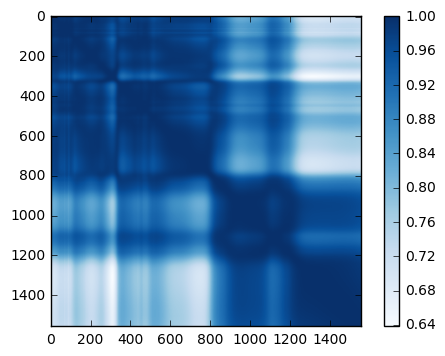

In [4]:
cor_data = pd.DataFrame(normalized).corr()

fig = plt.figure()
plt.imshow(cor_data, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

In [6]:
target = np.where(data['clase']=='sin adulterar', 0, 1)
X_train, X_test, y_train, y_test = train_test_split(normalized, target, test_size=.3, random_state=10)

model = LogisticRegression()# create the RFE model and select 10 from 1557 attributes
rfe = RFE(model, 10, step=10)
rfe = rfe.fit(X_train, y_train)
print(rfe.ranking_)

[61 78 95 ..., 51 53 55]


In [7]:
indices = np.where(rfe.support_)
new_data = normalized[:, indices[0]]
print("shape of new_data: {}".format(new_data.shape))

shape of new_data: (566, 10)


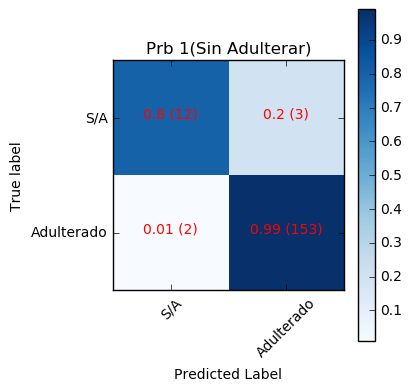

[ 0.98591549  0.90721649  0.93939394  0.9119171   0.97674419]


0.81152993348115299

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, n_jobs=4, n_estimators=20, criterion="gini")
clf.fit(X_train[:, indices[0]], y_train)
p = clf.predict(X_test[:, indices[0]])
cm = confusion_matrix(y_pred=p, y_true=y_test)

plot_confusion_matrix(classes=["S/A", "Adulterado"], cm=cm, norm=True, title="Prb 1(Sin Adulterar)")
val = cross_val_score(estimator=clf, X=normalized[:, indices[0]], y=target, n_jobs=4, scoring="f1", cv=5)
print(val)
cohen_kappa_score(y_test, p)

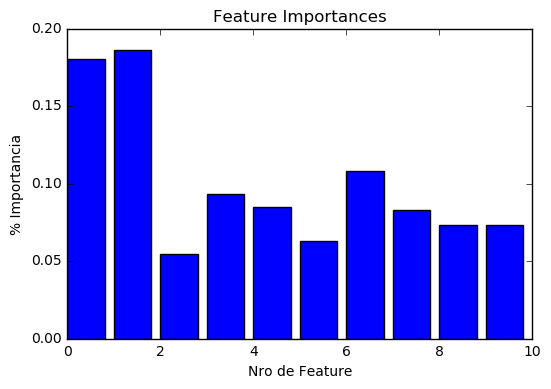

In [9]:
f = plt.figure()
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.title("Feature Importances")
plt.xlabel("Nro de Feature")
plt.ylabel("% Importancia")
plt.show()

## Intentando hacer lo mismo con todas las clases

Detectando 'sudan 4 - 5%'


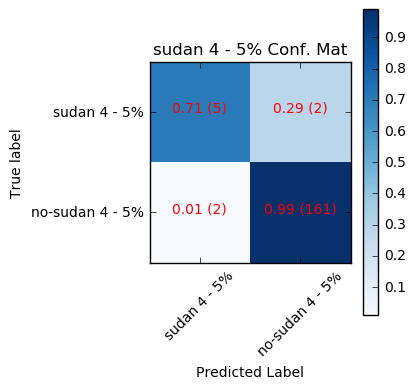

[ 0.98130841  0.97674419  0.99526066  0.95145631  0.97630332]
Kappa's Cohen test: 0.7020157756354075





Detectando 'sudan 4 - 2,5%'


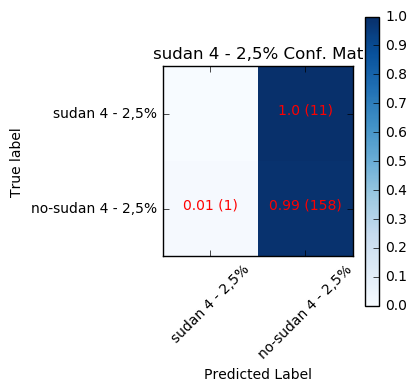

[ 0.94883721  0.96330275  0.96330275  0.96330275  0.96296296]
Kappa's Cohen test: -0.01090188305252715





Detectando 'sudan 2 - 2,5%'


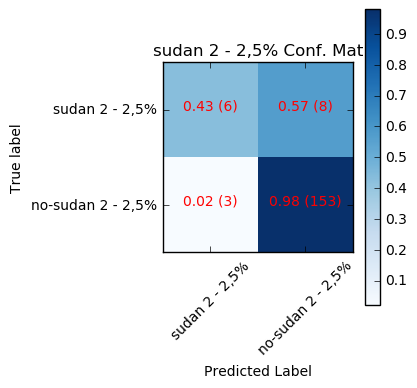

[ 0.93719807  0.96226415  0.96774194  0.97674419  0.97196262]
Kappa's Cohen test: 0.4887916894477857





Detectando 'sudan 4 - 1%'


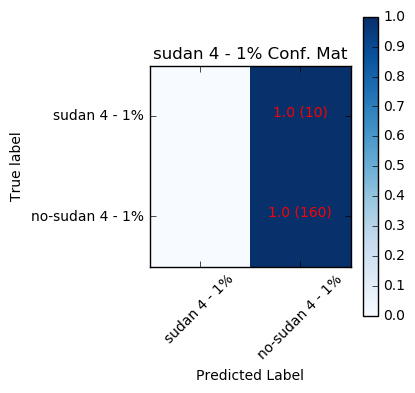

[ 0.9537037   0.96744186  0.96330275  0.96296296  0.93896714]
Kappa's Cohen test: 0.0





Detectando 'sudan 1 - 5%'


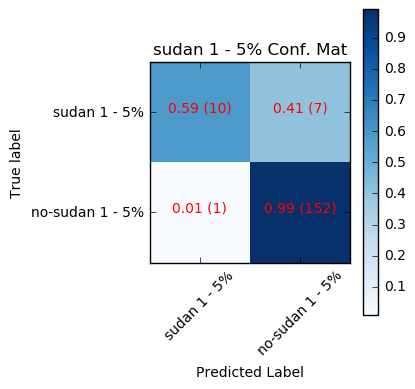

[ 0.98591549  0.98591549  0.87958115  0.99056604  0.98113208]
Kappa's Cohen test: 0.689922480620155





Detectando 'sudan 2 - 1%'


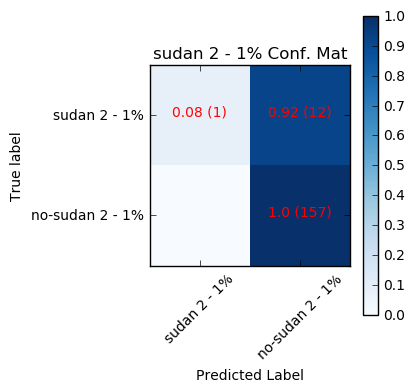

[ 0.95890411  0.96261682  0.96774194  0.96330275  0.9537037 ]
Kappa's Cohen test: 0.13338997451146983





Detectando 'sudan 1 - 2,5%'


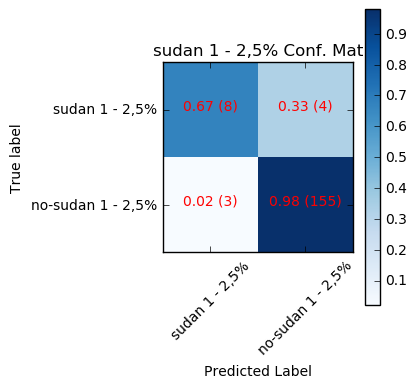

[ 0.98591549  0.79096045  0.92079208  0.98578199  0.99056604]
Kappa's Cohen test: 0.6736149204607789





Detectando 'sudan 2 - 5%'


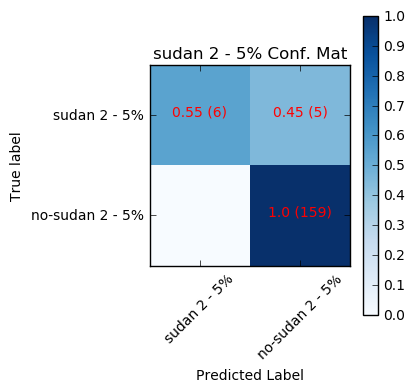

[ 0.97674419  0.97222222  0.99056604  0.9569378   0.89795918]
Kappa's Cohen test: 0.6918056562726613





Detectando 'sin adulterar'


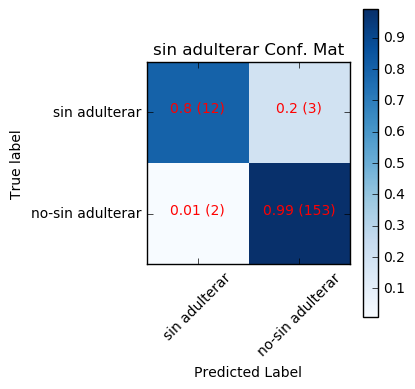

[ 0.99056604  0.98095238  0.93939394  0.92307692  0.99056604]
Kappa's Cohen test: 0.811529933481153





Detectando 'para red - 5%'


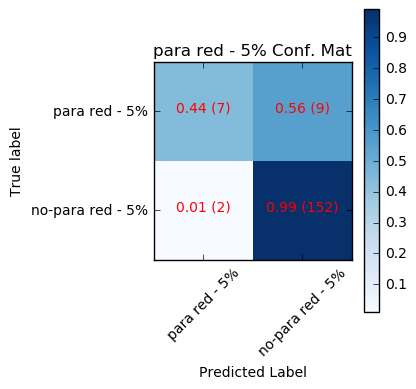

[ 0.96682464  0.97674419  0.97674419  0.97087379  0.97652582]
Kappa's Cohen test: 0.5280161534578496





Detectando 'sudan 3 - 5%'


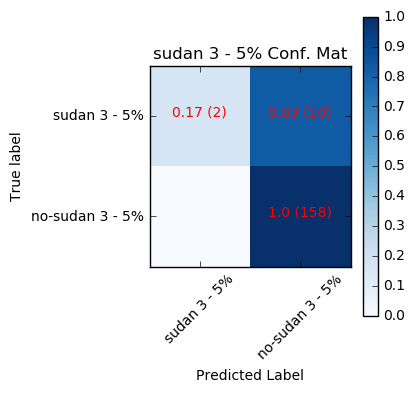

[ 0.87309645  0.97222222  0.93719807  0.95813953  0.97222222]
Kappa's Cohen test: 0.2710120068610635





Detectando 'para red - 1%'


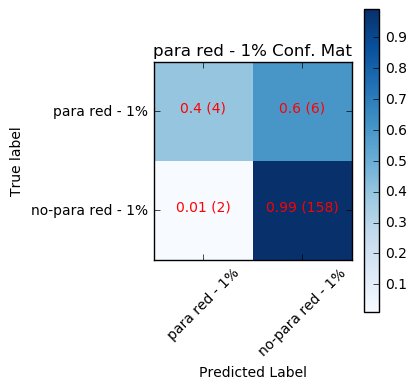

[ 0.96363636  0.96153846  0.97169811  0.98130841  0.96190476]
Kappa's Cohen test: 0.4769230769230769





Detectando 'sudan 1 - 1%'


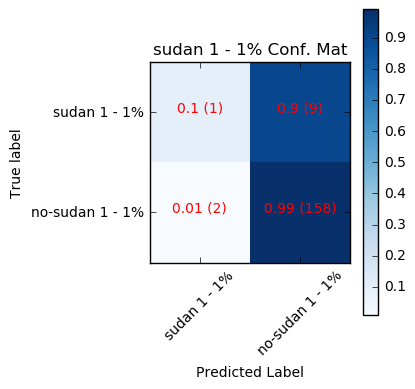

[ 0.96330275  0.94883721  0.96296296  0.9537037   0.95774648]
Kappa's Cohen test: 0.13023255813953494





Detectando 'para red - 2,5%'


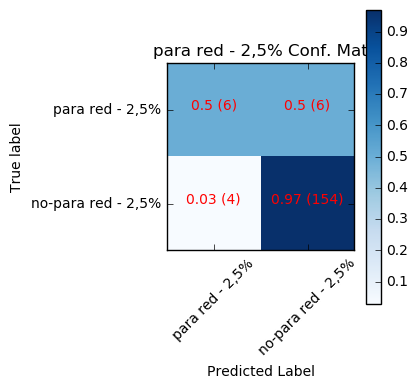

[ 0.96713615  0.97674419  0.95774648  0.96713615  0.98591549]
Kappa's Cohen test: 0.5142857142857143







In [10]:
for i, c in enumerate(loader.datos.keys()):
    print("Detectando '{}'".format(c))
    model = LogisticRegression(class_weight="balanced")
    # create the RFE model to select 30 of 1557 attributes
    rfe = RFE(model, 30, step=30)
    target = np.where(data['clase']==c, 0, 1)

    X_train, X_test, y_train, y_test = train_test_split(normalized, target, test_size=.3, random_state=10)
 
    rfe = rfe.fit(X_train, y_train)

    indices = np.where(rfe.support_)   # Rank of each feature. 1 means the feature was selected
    new_data = normalized[:, indices[0]]
    
#     clf = ExtraTreesClassifier(max_depth=4, n_jobs=4, n_estimators=20)
    clf = RandomForestClassifier(max_depth=6, n_jobs=4, n_estimators=20, criterion="gini")
    clf.fit(X_train[:, indices[0]], y_train)
    p = clf.predict(X_test[:, indices[0]])
    cm = confusion_matrix(y_pred=p, y_true=y_test)

    plot_confusion_matrix(classes=[c, "no-{}".format(c)], cm=cm, norm=True, title="{} Conf. Mat".format(c) )
    val = cross_val_score(estimator=clf, X=new_data, y=target, n_jobs=4, scoring="f1", cv=5)
    print(val)
    print("Kappa's Cohen test: {}".format(cohen_kappa_score(y_test, p)))
    print("\n\n\n\n")